In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


warnings.filterwarnings('ignore')

In [2]:
MAIN_FOLDER = "/home/arman/it/AI_work/machine/loans"

In [3]:
train_data = pd.read_csv(f"{MAIN_FOLDER}/data/train.csv")
test_data = pd.read_csv(f"{MAIN_FOLDER}/data/test.csv")
sample_sub = pd.read_csv(f"{MAIN_FOLDER}/data/sample_submission.csv")
print(train_data.columns.tolist()[:10])
train_data.head()

['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status']


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [4]:
print("Количество пропусков в тренировочном датасете:")
print(train_data.isnull().sum())

print("Количество пропусков в тестовом датасете:")
print(test_data.isnull().sum())

Количество пропусков в тренировочном датасете:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64
Количество пропусков в тестовом датасете:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
dtype: int64


In [5]:
analyze_df = train_data.copy()

analyze_df = analyze_df.drop(columns=["id", "loan_purpose", ])
analyze_df = pd.get_dummies(analyze_df, columns=["employment_status", "marital_status", "gender", "education_level"], drop_first=True)
analyze_df["grade_subgrade"] = analyze_df["grade_subgrade"].map(lambda x: (ord(x[0]) - 65)*10+int(x[1])).astype(int)


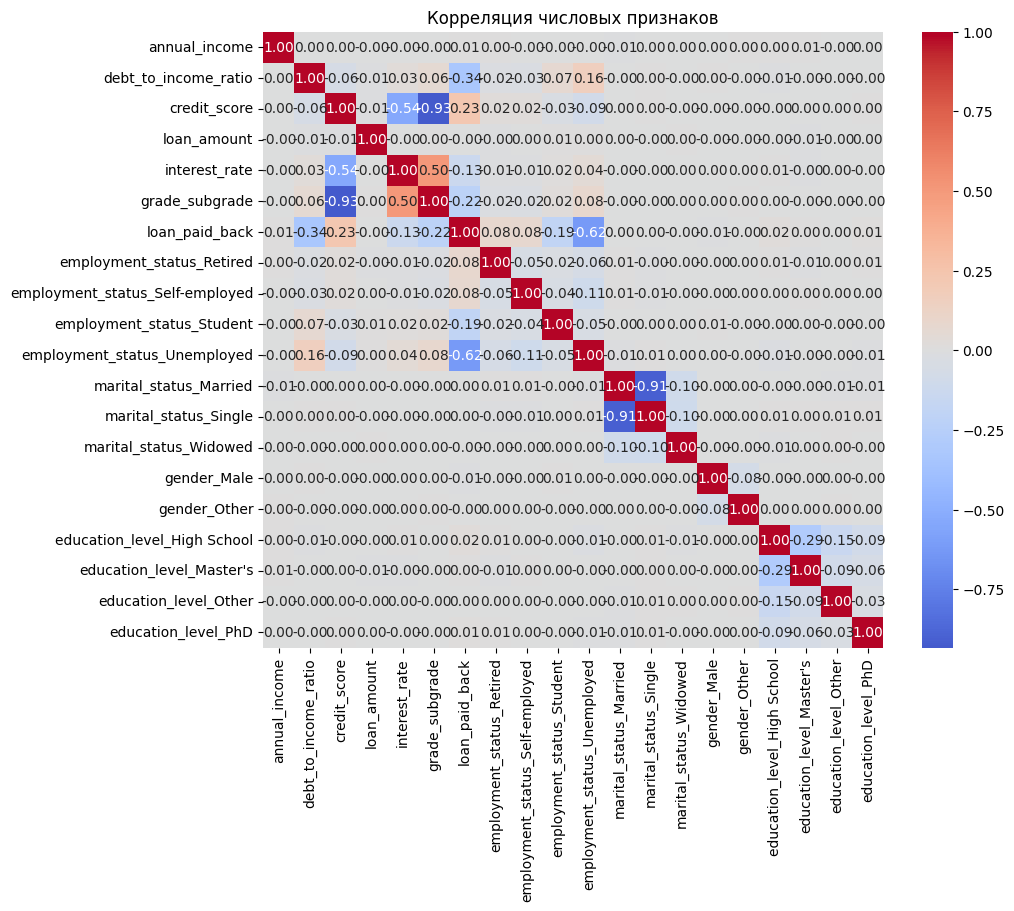

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(analyze_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция числовых признаков')
plt.show()

In [7]:
train_data = train_data.drop(columns=["id", "loan_purpose", ])
train_data = pd.get_dummies(train_data, columns=["employment_status"], drop_first=True)
train_data["grade_subgrade"] = train_data["grade_subgrade"].map(lambda x: (ord(x[0]) - 65)*10+int(x[1])).astype(int)

# not meaning
train_data = train_data.drop(columns=["marital_status", "gender", "education_level", "loan_amount", "annual_income", "employment_status_Retired", "employment_status_Self-employed"])

train_data["loan_paid_back"] = train_data["loan_paid_back"].astype(int)


train_data.head()

,debt_to_income_ratio,credit_score,interest_rate,grade_subgrade,loan_paid_back,employment_status_Student,employment_status_Unemployed
0,0.084,736,13.67,23,1,False,False
1,0.166,636,12.92,33,0,False,False
2,0.097,694,9.76,25,1,False,False
3,0.065,533,16.10,51,1,False,False
4,0.053,665,10.21,31,1,False,False


In [8]:
test_data = test_data.drop(columns=["loan_purpose", ])
test_data = pd.get_dummies(test_data, columns=["employment_status"], drop_first=True)
test_data["grade_subgrade"] = test_data["grade_subgrade"].map(lambda x: (ord(x[0]) - 65)*10+int(x[1])).astype(int)

# not meaning
test_data = test_data.drop(columns=["marital_status", "gender", "education_level", "loan_amount", "annual_income", "employment_status_Retired", "employment_status_Self-employed"])


test_data.head()

,id,debt_to_income_ratio,credit_score,interest_rate,grade_subgrade,employment_status_Student,employment_status_Unemployed
0,593994,0.049,626,14.73,35,False,False
1,593995,0.093,732,12.85,21,False,False
2,593996,0.367,611,13.29,31,False,False
3,593997,0.110,671,9.57,23,False,False
4,593998,0.081,688,12.80,21,False,False


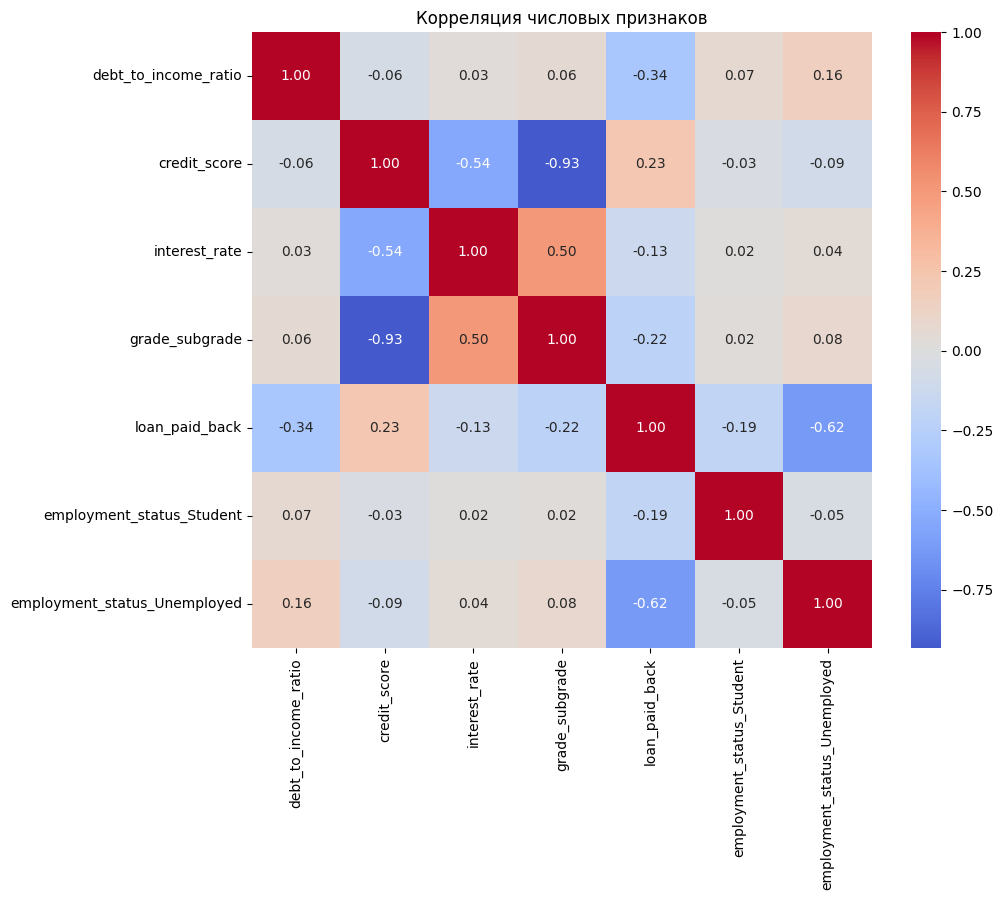

In [9]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция числовых признаков')
plt.show()

In [10]:
X = train_data.drop(columns=["loan_paid_back"])
y = train_data['loan_paid_back']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
test_y

523771    1
524810    1
100141    1
535634    1
518524    1
         ..
316972    1
467061    1
175172    1
153548    1
337271    0
Name: loan_paid_back, Length: 118799, dtype: int64

In [11]:
models = {
    'Ridge': Ridge(alpha=1.0, max_iter=100, random_state=42),
    'Lasso': Lasso(alpha=0.01, max_iter=100, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [12]:
for name, model in models.items():
    model.fit(train_X, train_y)
    pred_y = model.predict(test_X)
    accuracy = accuracy_score(test_y, pred_y > 0.5)
    auc = roc_auc_score(test_y, pred_y)
    print(f"name: {name} K")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"AUC: {auc:.2f} K")
    print("====")

name: Ridge K
Accuracy: 0.90
AUC: 0.91 K
====
name: Lasso K
Accuracy: 0.89
AUC: 0.86 K
====
name: Random Forest K
Accuracy: 0.89
AUC: 0.89 K
====
name: Gradient Boosting K
Accuracy: 0.90
AUC: 0.91 K
====
name: XGBoost K
Accuracy: 0.90
AUC: 0.92 K
====
name: RandomForestClassifier K
Accuracy: 0.90
AUC: 0.79 K
====


In [13]:
main_name = "RandomForestClassifier"
main_model = models[main_name]
if main_name == "RandomForestClassifier":
    test_pred_proba = model.predict_proba(test_data.drop(columns=["id"]))[:, 1]
else:
    test_pred_proba = model.predict(test_data.drop(columns=["id"])) > 0.5

In [15]:
submission = pd.DataFrame({
    'id': test_data['id'],
    'loan_paid_back': test_pred_proba
})
submission['loan_paid_back'] = (submission['loan_paid_back'] > 0.5).astype(int)

submission.to_csv(f"{MAIN_FOLDER}/data/rf_submission.csv", index=False)